In [1]:
### Setup the environment
import pandas as pd
import pandas_datareader as web
import numpy as np
import datetime
import matplotlib
import os
import scipy as sp
import scipy.optimize as scopt
import scipy.stats as spstats
import warnings
warnings.filterwarnings("ignore")
matplotlib.use('TKAgg')
%matplotlib inline
import pylab as py
py.ion()

HOME=os.environ['HOME']

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
## Get Portfolio
import sys
sys.path.append('%s/Work/Python/Git_Folder/investmenttools'%HOME)
import investmenttools.PortfolioBuilder as PB
P=PB.Portfolio('%s/Work/Python/Git_Folder/investmenttools/Simple_Portfolio.txt'%HOME)
P.ReadPortfolio()
P.Stocks=[s.replace('.','-') for s in P.Stocks]
print P.Stocks
print P.Weight

['brk-b', 'gld', 'tlo', 'bsv']
[25.0, 25.0, 25.0, 25.0]


In [16]:
### Get Historical Data for individual equity in the stock
def get_historical_closes(tickers,start,end):
    def data(ticker):
        return web.DataReader(ticker, 'yahoo', start, end)
    datas = map(data, tickers) ## this is a nice concept.. map applies function "data" to the items of sequence "ticker"
    all_data=pd.concat(datas, keys=tickers, names=['Ticker','Date'])
    all_data_reset = all_data[['Adj Close']].reset_index()
    pivot = all_data_reset.pivot('Date', 'Ticker','Adj Close')
    return pivot

ticker=['shy','shyg','vgsh','vcsh']
closes=get_historical_closes(P.Stocks,'2010-1-1','2012-12-31')
closes.head()


Ticker      brk-b     bsv     gld     tlo
Date                                     
2010-01-04  66.22  69.667  109.80  42.437
2010-01-05  66.54  69.842  109.70  42.829
2010-01-06  66.20  69.789  111.51  42.533
2010-01-07  66.46  69.807  110.82  42.397
2010-01-08  66.44  69.789  111.37  42.469

In [4]:
### Compute Annual Return for the Portfolio
def calc_daily_returns(closes):
    #Log of Pt/Pt-1
    return np.log(closes/closes.shift(1))
def calc_annual_returns(daily_returns):
    grouped = np.exp(daily_returns.groupby(lambda date: date.year).sum())-1
    return grouped

daily_returns=calc_daily_returns(closes)
annual_returns=calc_annual_returns(daily_returns)
annual_returns.head()

Ticker  brk-b    bsv    gld    tlo
2010    0.210  0.038  0.263  0.088
2011   -0.048  0.029  0.096  0.304
2012    0.176  0.015  0.066  0.026

In [15]:
nor_closes=closes/closes.iloc[0]
print type(nor_closes.index)

cv=nor_closes.corr()
cv

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


Ticker  brk-b    bsv    gld    tlo
Ticker                            
brk-b   1.000  0.354  0.139  0.298
bsv     0.354  1.000  0.915  0.930
gld     0.139  0.915  1.000  0.805
tlo     0.298  0.930  0.805  1.000

In [5]:
### Compute Portfolio Variance
def calc_portfolio_var(returns,weights=None):
    if weights is None:
        weights=np.ones(returns.columns.size)/returns.columns.size ### returns is of type Data-Frame
    sigma=np.cov(returns.T)
    var=(weights*sigma*weights.T).sum()
    return var
print calc_portfolio_var(annual_returns)


0.00163778147875


In [6]:
## Compute Sharp Ratio: S=(E(R)-Rf)/sigma_p
def sharpe_ratio(returns, weights = None, risk_free_rate = 0.015):
    n = returns.columns.size
    if weights is None: weights = np.ones(n)/n
    var = calc_portfolio_var(returns, weights)
    means = returns.mean()
    return (means.dot(weights) - risk_free_rate)/np.sqrt(var)

print sharpe_ratio(annual_returns)

2.23298222754


In [7]:
### Construct an optimal portfolio
def negative_sharpe_ratio_n_minus_1_stock(weights,returns,risk_free_rate):
    """
    Given n-1 weights, return a negative sharpe ratio
    """
    weights2 = sp.append(weights, 1-np.sum(weights))
    #print weights2
    return -sharpe_ratio(returns, weights2, risk_free_rate)

def neg_sharp(weights,returns,risk_free_rate=0.01):
    return -sharp_ratio(returns,weights,risk_free_rate)

def optimize_portfolio(returns, risk_free_rate):
    w0 = np.ones(returns.columns.size-1,dtype=float) * 1.0 / returns.columns.size
    #w0=np.array([.2,0,0])
    opt= scopt.minimize(negative_sharpe_ratio_n_minus_1_stock,w0, args=(returns, risk_free_rate),bounds=[(0,1),(0,1),(0,1)])
    w1=opt.x
    final_w = sp.append(w1, 1 - np.sum(w1))
    final_sharpe = sharpe_ratio(returns, final_w, risk_free_rate)
    print final_sharpe
    return (final_w, final_sharpe)

w,fs=optimize_portfolio(annual_returns, 0.015)
print w, w.sum()
print annual_returns.columns.size

2.23298222754
[ 0.25  0.25  0.25  0.25] 1.0
4


In [8]:
def neg_sharp(weights,returns,risk_free_rate=0.01):
    return -sharpe_ratio(returns,weights,risk_free_rate)

def direct_portfolio_optimize(returns,risk_free_rate=0.01):
    w0 = np.ones(returns.columns.size,dtype=float) * 1.0 / returns.columns.size
    bounds = [(0,1) for i in np.arange(returns.columns.size)]
    constraints = ({'type': 'eq','fun': lambda W: np.sum(W) - 1})
    results = scopt.minimize(neg_sharp, w0, (returns,risk_free_rate),method='SLSQP',constraints=constraints,bounds=bounds)
    return results.x

print direct_portfolio_optimize(annual_returns)

[ 0.03094631  0.03094003  0.03095769  0.90715597]


In [9]:
w0=np.ones(annual_returns.columns.size,dtype=float) * 1.0 / annual_returns.columns.size
R_suboptimal=w0*annual_returns
print 'Sub-optimal portfolio returns:', R_suboptimal.mean(axis=0).sum()
w_optim=direct_portfolio_optimize(annual_returns)
R_optimal=w_optim*annual_returns
print 'Optimal Portfolio returns:', R_optimal.mean(axis=0).sum()

Sub-optimal portfolio returns: 0.105367703184
Optimal Portfolio returns: 0.135377203153


In [10]:
## Efficient Frontier Calculation
def objfun(W, R, target_ret):
    stock_mean = np.mean(R,axis=0)
    port_mean = np.dot(W,stock_mean)
    cov=np.cov(R.T)
    port_var = np.dot(np.dot(W,cov),W.T)
    penalty = 2000*abs(port_mean-target_ret)
    return np.sqrt(port_var) + penalty


def calc_efficient_frontier(returns):
    result_means = []
    result_stds = []
    result_weights = []
    means = returns.mean()
    min_mean, max_mean = means.min(), means.max()
    nstocks = returns.columns.size
    for r in np.linspace(min_mean, max_mean, 100):
        weights = np.ones(nstocks)/nstocks
        bounds = [(0,1) for i in np.arange(nstocks)]
        constraints = ({'type': 'eq','fun': lambda W: np.sum(W) - 1})
        results = scopt.minimize(objfun, weights, (returns, r),
        method='SLSQP',
        constraints = constraints,
        bounds = bounds)
        if not results.success: # handle error
            raise Exception(result.message)
        result_means.append(np.round(r,4)) # 4 decimal places
        std_=np.round(np.std(np.sum(returns*results.x,axis=1)),6)
        result_stds.append(std_)
        result_weights.append(np.round(results.x, 5))
    return {'Means': result_means,'Stds': result_stds,'Weights': result_weights}

frontier_data = calc_efficient_frontier(annual_returns)

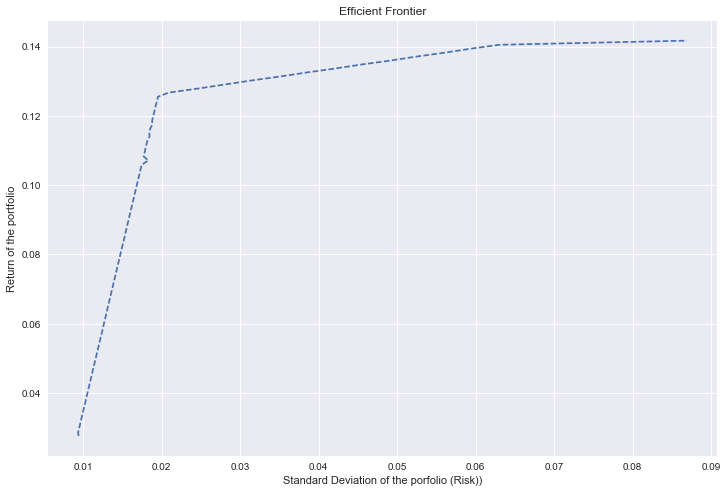

In [11]:
def plot_efficient_frontier(ef_data):
    py.figure(figsize=(12,8))
    py.title('Efficient Frontier')
    py.xlabel('Standard Deviation of the porfolio (Risk))')
    py.ylabel('Return of the portfolio')
    py.plot(ef_data['Stds'], ef_data['Means'], '--');

plot_efficient_frontier(frontier_data)